In [13]:
# import os
import numpy as np
import time

import seaborn as sns

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [14]:
file = "data.npy"
data = np.load(file, allow_pickle=True)
# delete the 5th column
# data = np.delete(data, 4, axis=1)

# check if all the game id's are unique
# np.unique(data[:, 0]).shape[0] 
# data = np.delete(data, 0, axis=1)

# print(data.shape, end='\n\n')

In [15]:
# get all the unique values for labels
x = np.array(np.unique(data[:, 3], return_counts=True)).T # Transposed for easier reading
x = x[x[:,1].argsort()] # sor
# print(x.shape)

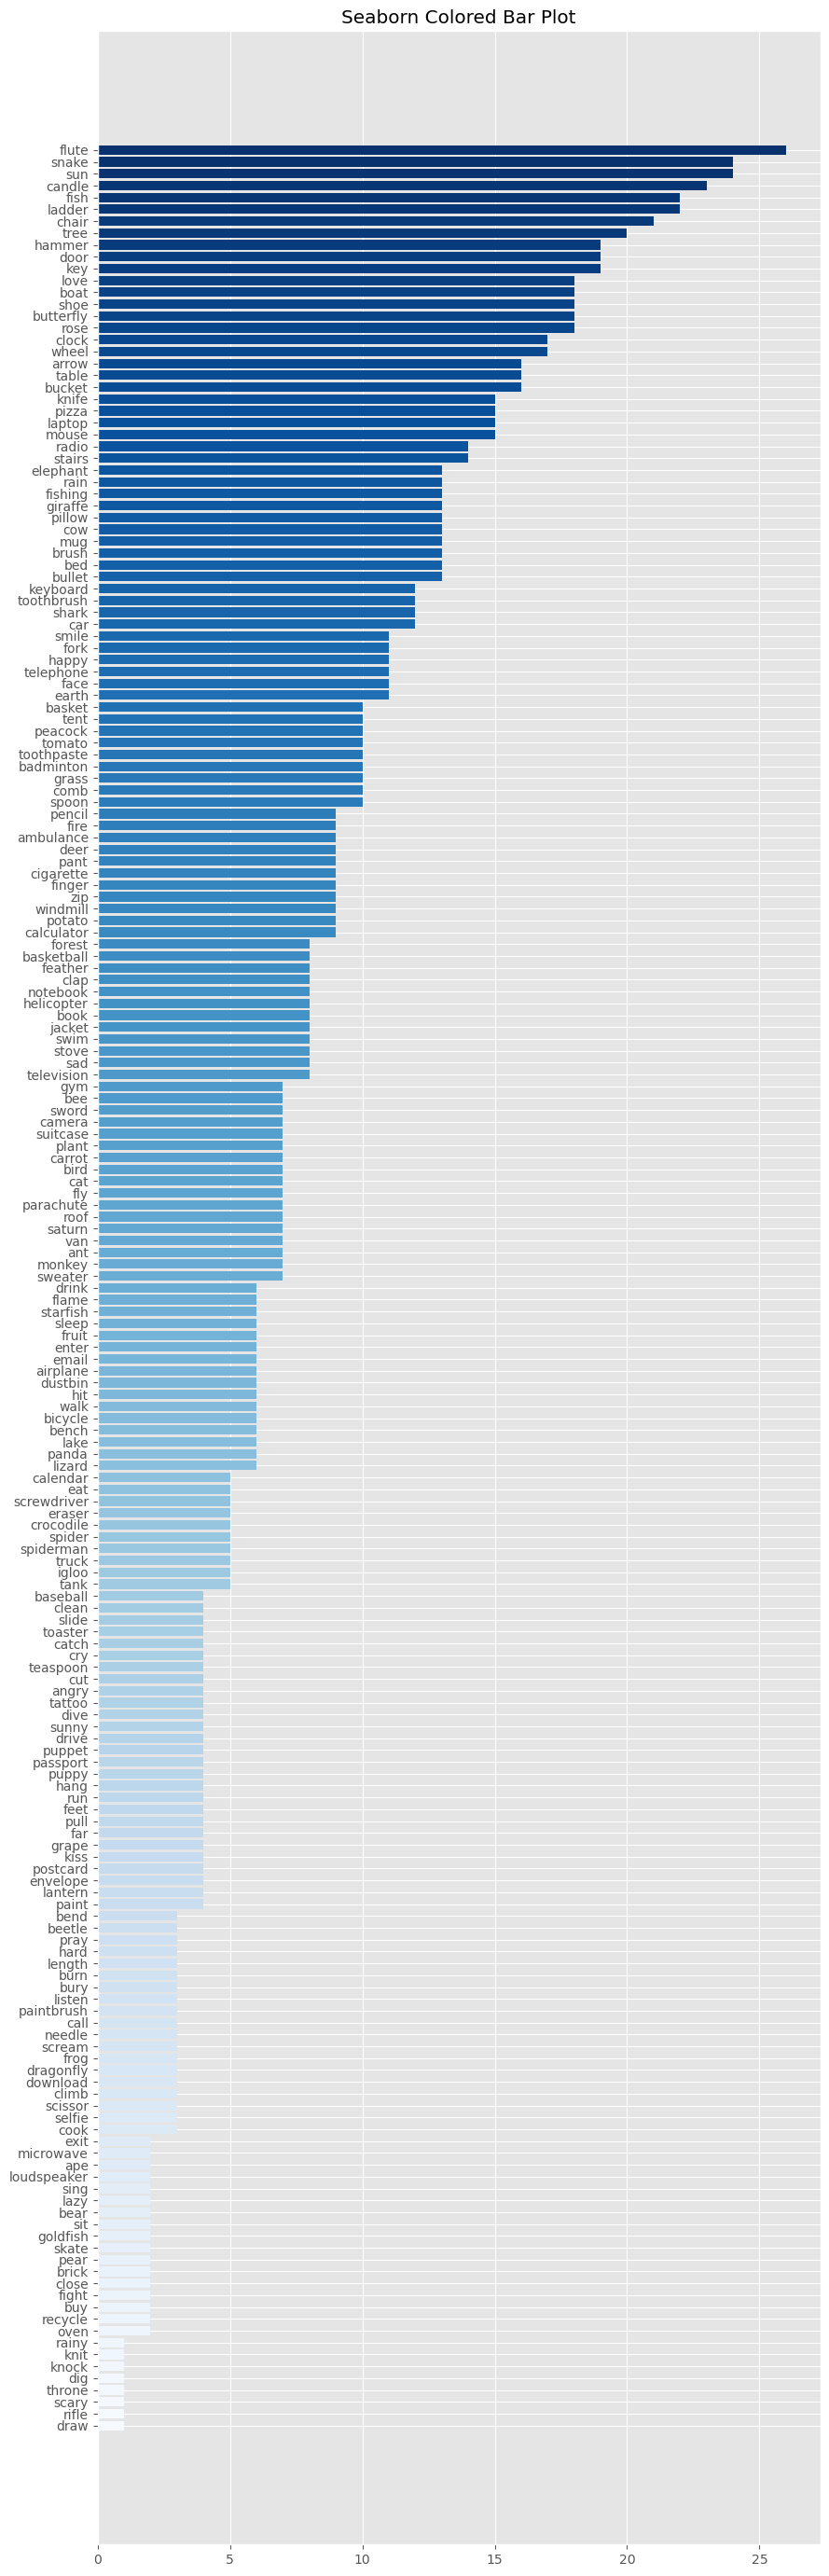

In [16]:

# Create a larger figure with adjusted width and height
plt.figure(figsize=(10, 35))

# Create the bar plot with Seaborn's color palette
num_bars = x.shape[0]
color_palette = sns.color_palette("Blues", num_bars)  # You can choose a different palette
bars = plt.barh(x[:,0], x[:, 1], color=color_palette)

# Customize the plot
# plt.xlabel('X Label')  # Set your x-axis label
# plt.ylabel('Y Label')  # Set your y-axis label
plt.title('Seaborn Colored Bar Plot')  # Set your plot title

# Show the plot
plt.show()

#### $k$ is the number of nearest neighbors
#### $k$ must be $odd$
#### $k \;< \;\sqrt{n}$
#### Here $k \;<\; \sqrt{1500}$
#### $k \;< \;39$

In [17]:
resnet_index = 1
vit_index = 2
label_index = 3

X_resnet = []
for d in data[:, resnet_index]:
    X_resnet.append(d.reshape(-1))
X_resnet = np.array(X_resnet)

X_vit = []
for d in data[:, vit_index]:
    X_vit.append(d.reshape(-1))
X_vit = np.array(X_vit)

y = data[:, label_index]

X_resnet_train, X_resnet_test, y_resnet_train, y_resnet_test = train_test_split(X_resnet, y, test_size=0.2, random_state=2)
X_vit_train, X_vit_test, y_vit_train, y_vit_test = train_test_split(X_vit, y, test_size=0.2, random_state=2)

In [18]:
class KNNClassifier:
    def __init__(self, k=3, distance_metric='euclidean', encoder="ResNet"):
        self.k = k
        self.distance_metric = distance_metric
        self.encoder = encoder
        if self.encoder == "ResNet":
            self.X_train = X_resnet_train
            self.y_train = y_resnet_train
            self.X_test = X_resnet_test
            self.y_test = y_resnet_test
        elif self.encoder == "VIT":
            self.X_train = X_vit_train
            self.y_train = y_vit_train
            self.X_test = X_vit_test
            self.y_test = y_vit_test
        self.min = self.X_train.min(axis=0)
        self.max = self.X_train.max(axis=0)

        self.mean = self.X_train.mean(axis=0)
        self.std = self.X_train.std(axis=0)

        self.X_train = self.min_max_normalization(self.X_train)
        # very poor performance with min max normalization
        # self.X_train = self.standard_normalization(self.X_train)
        
        


        # TODO: apply nomalization to X_train
        # Either Min Max or Standard
    
    # def standard_normalization(self, X_train):
    #     return (X_train - self.mean) / self.std

    # def standard_normalization_for_pred(self, x):
    #     return (x - self.mean) / self.std
    
    def min_max_normalization(self, X_train):
        return (X_train - self.min) / (self.max - self.min)
   
    # def min_max_normalization_for_pred(self, x):
    #     return (x - self.min) / (self.max - self.min)

    def euclidean_distance(self, x):
        return np.sqrt(np.sum((self.X_train - x)**2, axis=1))
    def manhattan_distance(self, x):
        return np.sum(np.abs(self.X_train - x), axis=1)

    def cosine_distance(self, x):
        return (1 - (np.sum(self.X_train * x, axis=1) / (np.sqrt(np.sum(self.X_train**2, axis=1)) * np.sqrt(np.sum(x**2)))))
    def minkowski_distance(self, x, p=3):
        return np.sum(np.abs(self.X_train - x)**p, axis=1)**(1/p)
    
    def predict(self, X):
        predictions = []
        inference_time = []
        
        # x = self.min_max_normalization_for_pred(X)

        for x in X:
            x = self.min_max_normalization(x)
            # x = self.standard_normalization_for_pred(x)
            # print(x.shape)
            start_time = time.time()

            prediction = self.real_predict(x)
            inference_time.append(time.time() - start_time)
            predictions.append(prediction)
        
        return np.array(predictions), inference_time
    # 31 % accuracy
    # def real_predict(self, x):
    #     distances = np.zeros(self.X_train.shape[0])
    #     if self.distance_metric == 'euclidean':
    #         distances = self.euclidean_distance(x)
    #     elif self.distance_metric == 'cosine':
    #         distances = self.cosine_distance(x)
    #     elif self.distance_metric == 'manhattan':
    #         distances = self.manhattan_distance(x)
    #     elif self.distance_metric == 'minkowski':
    #         distances = self.minkowski_distance(x)

    #     k_indices = np.argsort(distances)[:self.k]
    #     k_nearest_labels = self.y_train[k_indices]

    #     unique_labels, label_counts = np.unique(k_nearest_labels, return_counts=True)
        
    #     # Handle tie-breaking
    #     max_count = np.max(label_counts)
    #     most_common_labels = unique_labels[label_counts == max_count]
        
    #     # If there's no tie, simply return the most common label
    #     if len(most_common_labels) == 1:
    #         return most_common_labels[0]
        
    #     # If there's a tie, choose the label that appears first in the array
    #     # This is one way to handle tie-breaking 
    #     for label in k_nearest_labels:
    #         if label in most_common_labels:
    #             return label


    def real_predict(self, x):
        distances = np.zeros(self.X_train.shape[0])
        if self.distance_metric == 'euclidean':
            distances = self.euclidean_distance(x)
        elif self.distance_metric == 'cosine':
            distances = self.cosine_distance(x)
        elif self.distance_metric == 'manhattan':
            distances = self.manhattan_distance(x)
        elif self.distance_metric == 'minkowski':
            distances = self.minkowski_distance(x)

        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = self.y_train[k_indices]
        k_nearest_distances = distances[k_indices]

        unique_labels, count = np.unique(k_nearest_labels, return_counts=True)
        
        # Calculate weights based on inverse distances
        weights = 1 / (k_nearest_distances + 1e-10)  # Avoid division by zero
        
        # Create a dictionary to store the weighted counts for each label
        weighted_count_dict = {}
        for label in unique_labels:
            indices = np.where(k_nearest_labels == label)
            weighted_count_dict[label] = np.sum(weights[indices])
        weighted_count_dict
        
        # Find the label with the highest weighted count
        most_common_labels = max(weighted_count_dict, key=weighted_count_dict.get)
        
        return most_common_labels

# TODO: TEST below code 
    # def real_predict(self, x):
    #         distances = np.zeros(self.X_train.shape[0])
    #         if self.distance_metric == 'euclidean':
    #             distances = self.euclidean_distance(x)
    #         elif self.distance_metric == 'cosine':
    #             distances = self.cosine_distance(x)
    #         elif self.distance_metric == 'manhattan':
    #             distances = self.manhattan_distance(x)
    #         elif self.distance_metric == 'minkowski':
    #             distances = self.minkowski_distance(x)

    #         # Calculate weights based on distances
    #         weights = 1.0 / (distances + 1e-10)  # Adding a small value to avoid division by zero
            
    #         k_indices = np.argsort(distances)[:self.k]
    #         k_nearest_labels = self.y_train[k_indices]
            
    #         unique_labels = np.unique(k_nearest_labels)
            
    #         # Calculate weighted label counts
    #         weighted_label_counts = np.zeros(len(unique_labels))
    #         for i, label in enumerate(unique_labels):
    #             label_indices = np.where(k_nearest_labels == label)
    #             weighted_label_counts[i] = np.sum(weights[label_indices])
            
    #         # Find the label with the highest weighted count
    #         predicted_label_idx = np.argmax(weighted_label_counts)
    #         predicted_label = unique_labels[predicted_label_idx]
            
            # return predicted_label


    def get_inference_and_scores(self, type="micro"):
        prediction, inference_time = self.predict(self.X_test)

        # print(accuracy_score(y_pred=prediction, y_true=self.y_test))
        # print(precision_score(y_pred=prediction, y_true=self.y_test, average=type))
        # print(recall_score(y_pred=prediction, y_true=self.y_test, average=type))
        # print(f1_score(y_pred=prediction, y_true=self.y_test, average=type))
        # print(accuracy_score(y_pred=prediction, y_true=self.y_test))
        dict = classification_report(y_pred=prediction, y_true=self.y_test, zero_division=0, output_dict=True)
        return {
            "prediction":prediction,
            "dict":dict
                }
        

In [19]:
list = []
for enc in  ['VIT', 'ResNet']:
    for dis in ['euclidean', 'cosine', 'manhattan', 'minkowski']:
        for k in range(1, 39):
            knn = KNNClassifier(k = k, encoder=enc, distance_metric=dis)
            pred_and_scores = knn.get_inference_and_scores()
            # print(enc, dis, k, pred_and_scores['dict']['accuracy'])
            list.append([enc, dis, k, pred_and_scores['dict']['accuracy']])

min_max = np.array(list)
k_vs_acc = min_max.copy()


# knn.get_inference_and_scores(type="macro")
# pred_and_scores['prediction']
# pred_and_scores['dict']['accuracy']
# pred_and_scores['dict']['weighted avg']
# pred_and_scores['dict']['macro avg']


In [ ]:
listl = []
for enc in  ['VIT']:
    for dis in ['cosine']:
        for k in range(7, 9 + 1):
            knn = KNNClassifier(k = k, encoder=enc, distance_metric=dis)
            pred_and_scores = knn.get_inference_and_scores()
            # print(enc, dis, k, pred_and_scores['dict']['accuracy'])
            listl.append([enc, dis, k, pred_and_scores['dict']['accuracy']])

In [20]:
# Find the best (k, encoder, distance metric) triplet that gives the best
# validation accuracy for a given data split (your choice).

min_max[np.flip(min_max[:,3].argsort())][:1]

array([['VIT', 'cosine', '11', '0.31']], dtype='<U32')

In [26]:
# Print an Ordered rank list of top 20 such triplets.

min_max[np.flip(min_max[:,3].argsort())][:20]

array([['VIT', 'cosine', '11', '0.31'],
       ['VIT', 'manhattan', '8', '0.30333333333333334'],
       ['VIT', 'cosine', '10', '0.3'],
       ['VIT', 'cosine', '12', '0.2966666666666667'],
       ['VIT', 'euclidean', '12', '0.2966666666666667'],
       ['VIT', 'cosine', '5', '0.2966666666666667'],
       ['VIT', 'cosine', '6', '0.2966666666666667'],
       ['VIT', 'cosine', '7', '0.2966666666666667'],
       ['VIT', 'minkowski', '15', '0.2966666666666667'],
       ['VIT', 'minkowski', '11', '0.2966666666666667'],
       ['VIT', 'euclidean', '6', '0.2966666666666667'],
       ['VIT', 'euclidean', '8', '0.2966666666666667'],
       ['VIT', 'euclidean', '7', '0.2966666666666667'],
       ['VIT', 'manhattan', '7', '0.29333333333333333'],
       ['VIT', 'euclidean', '11', '0.29333333333333333'],
       ['VIT', 'minkowski', '13', '0.29333333333333333'],
       ['VIT', 'cosine', '8', '0.29333333333333333'],
       ['VIT', 'minkowski', '14', '0.29'],
       ['VIT', 'euclidean', '5', '0.29'],


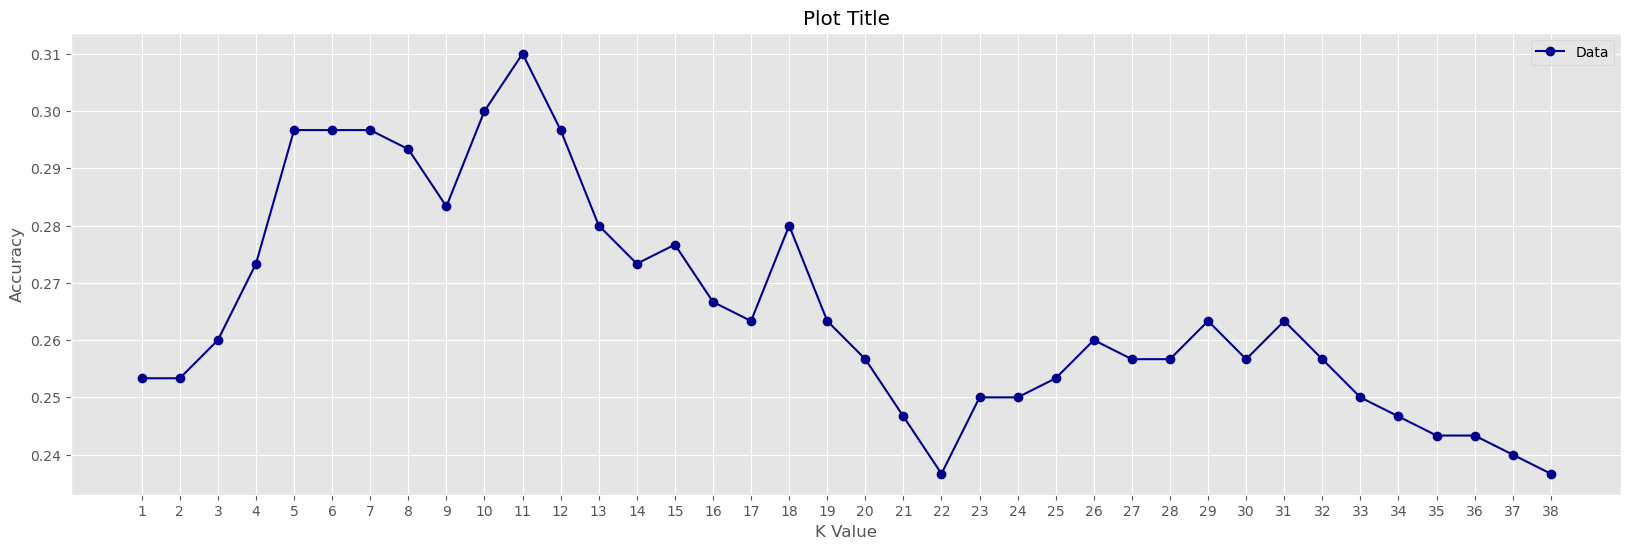

In [25]:
k_vs_acc = k_vs_acc[(k_vs_acc[:, 0]=='VIT') & (k_vs_acc[:, 1]=='cosine') ]
x_data = k_vs_acc[:, 2].astype(int)
y_data = k_vs_acc[:, 3].astype(float)

plt.style.use('ggplot')  # Choose a pleasing style
plt.figure(figsize=(20, 6))  # Adjust the figure size as needed
plt.plot(x_data, y_data, marker='o', linestyle='-', color='darkblue', label='Data')

# Add labels and title
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.xticks(x_data)
plt.title('Plot Title')

# Add grid and legend
plt.grid(True)
plt.legend()

# Add any other customizations you want

# Show the plot
plt.show()

### Task 2.2.1
Done
### Task 2.3.1
Done
### Task 2.4 
Done with all three